In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math

In [2]:
class Hydrogen:
    def __init__(self, units="atomic", azimuthal_number=0, principal_number=1, energy=-1):
        self.units = units
        self.azimuthal_number = azimuthal_number  # quantum number l
        self.energy = energy  # ground state energy in atomic units

    def compute_radial_equation_error(self, r_data, R_matrix, T_matrix, coefficients):
        num_data_points = np.shape(R_matrix)[0]
        energy_vector = np.full(num_data_points, self.energy)
        r_inverse_vector = np.array([1/r for r in r_data])
        r_inverse_squared_vector = np.array([1/(r**2) for r in r_data])
        error = np.matmul(T_matrix, coefficients) - \
                (-2*energy_vector + \
                 self.azimuthal_number*(self.azimuthal_number + 1)*r_inverse_squared_vector - \
                 2*r_inverse_vector)*np.matmul(R_matrix, coefficients)
        return error
    
    def cost_function_deriv(self, r_data, R_matrix, T_matrix, coefficients):
        
        A = self.compute_radial_equation_error(r_data, R_matrix, T_matrix, coefficients)
        num_data_points = np.shape(R_matrix)[0]
        energy_vector = np.full(num_data_points, self.energy)
        r_inverse_vector = np.array([1/r for r in r_data])
        r_inverse_squared_vector = np.array([1/(r**2) for r in r_data])
        G = ((-2*energy_vector + \
                 self.azimuthal_number*(self.azimuthal_number + 1)*r_inverse_squared_vector - \
                 2*r_inverse_vector))
        GR = np.zeros(T_matrix.shape)
        derivative = np.zeros(len(coefficients))
        for i in range(np.shape(R_matrix)[0]):
            for j in range(np.shape(R_matrix)[1]):
                GR[i][j]=G[i]*R_matrix[i][j]
        B = T_matrix - GR
        derivative = np.matmul(A,B)
        return(derivative)

In [3]:
def cost_function(u_pred, r_data, R_matrix, T_matrix, coefficients, hydrogen):
    """Compute cost function.

    The radial function for Hydrogen is a second order ODE, which can be set to zero by bringing
    all the terms to one side. Our prediction for u(r) for each iteration can be substituted into
    this equation, and should be close to zero. This is how we define our error.

    Args:
        u_pred: (np.array)
        r_data: (np.array) a (1 x n) vector containing the input radial data
        R_matrix: (np.array) an (n x m) matrix, see ``create_R_matrix``
        T_matrix: (np.array) an (n x m) matrix, 2nd derivative, see ``create_T_matrix``
        coefficients: (np.array) a (1 x m) vector containing the predicted coefficients
        hydrogen: (Hydrogen) a Hydrogen object

    """
    error = hydrogen.compute_radial_equation_error(r_data, R_matrix, T_matrix, coefficients)
    squared_difference = np.dot(error, error)
    return squared_difference/len(r_data)


def create_R_matrix(num_data_points, polynomial_degree, r_data):
    """Create a matrix of polynomials.

        [
            1, r_1, r_1^2, ... r_1^m

            ...

            1, r_n, r_n^2, ... r_n^m

        ]

    Args:
        num_data_points: (int) number of data points to be used in the linear regression (n)
        polynomial_degree: (int) maximum degree of the polynomial (m)
        r_data: (np.array) a (1 x n) vector containing the input radial data

    """
    R_matrix = np.ones((num_data_points, polynomial_degree))
    row = 0
    for r in r_data:
        for n in range(0, polynomial_degree):
            R_matrix[row][n] = r**n
        row = row + 1
    return R_matrix


def create_T_matrix(num_data_points, polynomial_degree, r_data):
    """Create a matrix of second derivative of polynomials.

        [
            0, 0, 2, 6*r_1, 12*r_1^2... m*(m-1)*r_1^(m-2)

            ...

            0, 0, 2, 6*r_n, 12*r_n^2... m*(m-1)*r_n^(m-2)

        ]

    Args:
        num_data_points: (int) number of data points to be used in the linear regression (n)
        polynomial_degree: (int) maximum degree of the polynomial (m)
        r_data: (np.array) a (1 x n) vector containing the input radial data

    """
    T_matrix = np.zeros((num_data_points, polynomial_degree))
    row = 0
    for r in r_data:
        for n in range(2, polynomial_degree):
            T_matrix[row][n] = n*(n-1)*r**(n-2)
        row = row + 1
    return T_matrix
    

def gradient_descent(n, hydrogen, r_data, num_data_points, alpha, R_matrix, T_matrix, coefficients):
    
    deriv_cost_function = hydrogen.cost_function_deriv(r_data, R_matrix, T_matrix, coefficients)
    return (alpha/num_data_points*deriv_cost_function)


We use gradient descend method to minimise the error between the polynomial approximation of the radial wavefunction and the wavefunction itself.

We are trying to minimise the cost function defined as 

$$ J(\theta) = \dfrac{1}{2m}  \sum_{i=0}^{m} [h(\theta,r_i)-f(r_i) ]^2 $$

where, $h_i(\theta,r_i)$ is the polynomial approximation of a function $f(r)$ which is the actual function of $r$.

$$ h_i(\theta) = {\theta}_{0}+{\theta}_{1}r_i^1+{\theta}_{2}r_i^2+{\theta}_{3}r_i^3 ...+{\theta}_{N}r_i^N $$
    
The update to coefficients ${\theta}_{k}$ is given as:

$$ {\theta}_{k}^{(j+1)} = {\theta}_{k}^{(j)} - \alpha \dfrac{\partial J}{\partial {\theta}_{k}^{(j)}}$$

$$ \frac{\partial J}{\partial {\theta}_{k}} = \dfrac{1}{m}  \sum_{i=0}^{m} [h_i(\theta_k, r_i)-f(r_i)] \dfrac{\partial [h(\theta_k, r_i)-f(r_i)]}{\partial {\theta_k}} $$
$$ = \dfrac{1}{m}  \sum_{i=0}^{m} [h_i(\theta_k, r_i)-f(r_i)]r^k $$
$$ 0 \leq k \leq N $$

where m is the number of data points.

1.548267479865716


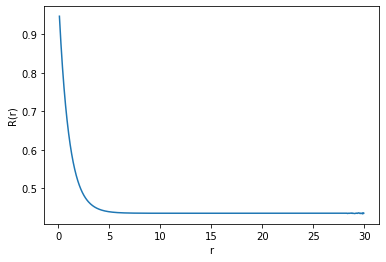

In [4]:
polynomial_degree = 100
r_data = np.arange(0.1, 30, 0.05)
num_data_points = len(r_data)
hydrogen = Hydrogen()
R_matrix = create_R_matrix(num_data_points, polynomial_degree, r_data)
T_matrix = create_T_matrix(num_data_points, polynomial_degree, r_data)
coefficients = np.ones(polynomial_degree)
for n in range(1, polynomial_degree):
    coefficients[n] = (-1)**n*(1/math.factorial(n))*1/np.sqrt(np.pi)*10**.00001
    #coefficients[n] = (-1/2)**(n)*(1/math.factorial(n)+1/math.factorial(n-1))*1/np.sqrt(2)
#coefficients[0]=1/np.sqrt(2)
alpha = 10**-300
max_iterations = 500
for n in range(0, max_iterations):
    h = hydrogen.compute_radial_equation_error(r_data, R_matrix, T_matrix, coefficients)
    f = 0
    coefficients = coefficients - gradient_descent(n, hydrogen, r_data, num_data_points, alpha, R_matrix, T_matrix, coefficients)
    u_pred = np.matmul(R_matrix, coefficients)
    cost = cost_function(u_pred, r_data, R_matrix, T_matrix, coefficients, hydrogen)
    if cost <= 0.001:
        break

print(cost)
plt.plot(r_data, u_pred)
plt.xlabel("r")
# plt.xlim(0,25)
# plt.ylim(0,1)
plt.ylabel("R(r)")
plt.show()